# 1. Imports and Setup

In this cell, we import all the necessary libraries and set up the working environment.


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_addons as tfa

In [ ]:
# Function to load configuration from a JSON file
def load_config(filename: str = "config.json") -> dict:
    """
    Loads the configuration from a JSON file.

    Parameters:
    - filename (str): The path to the configuration file.

    Returns:
    - dict: Configuration parameters loaded from the JSON file.
    """
    with open(filename, 'r') as f:
        return json.load(f)

# Load configuration
config = load_config()

In [ ]:
# Define global parameters
batch_size = config["transformers"]["batch_size"]  # Batch size for training
num_epochs = config["transformers"]["training"]["epochs"]  # Number of training epochs
image_size = config["transformers"]["image_size"]  # Image dimensions
metrics = config["transformers"]["training"]["metrics"]
loss = config["transformers"]["training"]["loss"]
optimizer = config["transformers"]["training"]["optimizer"] 
AUTOTUNE = tf.data.experimental.AUTOTUNE

# ViT-specific parameters
PATCH_SIZE = config["transformers"]["training"]["patch_size"]
PROJECTION_DIM = config["transformers"]["training"]["projection_dim"]
NUM_HEADS = config["transformers"]["training"]["num_heads"]
TRANSFORMER_UNITS = config["transformers"]["training"]["trasnformer_unit"]
TRANSFORMER_LAYERS = config["transformers"]["training"]["transformer_layer"] 
MLP_HEAD_UNITS = config["transformers"]["training"]["mlp_head_units"]
NUM_CLASSES = config["transformers"]["training"]["num_classes"] # Binary classification
NUM_PATCHES = config["transformers"]["training"]["num_patches"] 

model_save_path = "models/vit_rgb.h5"

# Define callbacks
classification_model_checkpoint = config["transformers"]["training"]["model_checkpoint"] 

early_stopping = config["transformers"]["training"]["early_stopping"]

reduce_lr_on_plateau = config["transformers"]["training"]["lr_scheduler"]

csv_logger = config["transformers"]["training"]["lr_scheduler"]

callbacks = [
    classification_model_checkpoint,
    early_stopping,
    reduce_lr_on_plateau,
    csv_logger
]

# 4 Pre-processing

In [ ]:
# Create a dataframe mapping image paths to their labels
def create_dataframe(label_0_folder, label_1_folder):
    """
    Create a Pandas dataframe containing image paths and their corresponding labels.

    Parameters:
        label_0_folder (str): Path to the folder containing class 0 images.
        label_1_folder (str): Path to the folder containing class 1 images.

    Returns:
        pd.DataFrame: A dataframe with columns `image_path` and `label`.
    """
    data = []
    for filename in os.listdir(label_0_folder):
        img_path = os.path.join(label_0_folder, filename)
        data.append((img_path, 0))

    for filename in os.listdir(label_1_folder):
        img_path = os.path.join(label_1_folder, filename)
        data.append((img_path, 1))

    df = pd.DataFrame(data, columns=["image_path", "label"])
    return df

# %%
# Load and preprocess images for classification
def load_and_preprocess_image_classification(image_path, label):
    """
    Load and preprocess images for classification tasks.

    Parameters:
        image_path (str): Path to the image file (numpy format).
        label (float): Corresponding label for the image.

    Returns:
        Tuple[tf.Tensor, float]: Preprocessed image tensor and its label.
    """
    def _load_image(image_path):
        image = np.load(image_path.decode('utf-8'))
        image = image.astype(np.float32)
        image = (image + 1) / 2.0  # Normalize from [-1, 1] to [0, 1]
        if image.ndim == 2:  # Grayscale images
            image = np.expand_dims(image, axis=-1)
        return image

    image = tf.numpy_function(_load_image, [image_path], tf.float32)
    image.set_shape([32, 32, 1])
    image = tf.image.resize(image, [image_size, image_size])
    return image, label


In [ ]:
# Paths to data folders
data_dir = "/media/neurone-pc6/Volume/Michele/Prog_GAF_Michele/pythonProject/data/RGB"
label_0_folder = os.path.join(data_dir, "Label_0")
label_1_folder = os.path.join(data_dir, "Label_1")

# Create dataframe
df = create_dataframe(label_0_folder, label_1_folder)
df["label"] = df["label"].astype(np.float32)

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create TensorFlow datasets
train_ds_classification = tf.data.Dataset.from_tensor_slices((train_df["image_path"].values, train_df["label"].values))
train_ds_classification = train_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

val_ds_classification = tf.data.Dataset.from_tensor_slices((val_df["image_path"].values, val_df["label"].values))
val_ds_classification = val_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

test_ds_classification = tf.data.Dataset.from_tensor_slices((test_df["image_path"].values, test_df["label"].values))
test_ds_classification = test_ds_classification.map(load_and_preprocess_image_classification, num_parallel_calls=AUTOTUNE).batch(1).prefetch(AUTOTUNE)

# 5 Model

In [ ]:
# Define the Patch Encoder class
class PatchEncoder(layers.Layer):
    """
    Custom Keras layer for patch encoding in Vision Transformers.

    Parameters:
        num_patches (int): Total number of patches in the image.
        projection_dim (int): Dimensionality of the projection space.
    """
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# %%
# Create the Vision Transformer (ViT) model
def create_vit_classifier():
    """
    Build a Vision Transformer (ViT) model for binary classification.

    Returns:
        tf.keras.Model: Compiled ViT model.
    """
    inputs = layers.Input(shape=(image_size, image_size, 1))

    # Patch extraction
    x = layers.Conv2D(filters=PROJECTION_DIM, kernel_size=PATCH_SIZE, strides=PATCH_SIZE, padding='valid')(inputs)
    x = layers.Reshape((NUM_PATCHES, PROJECTION_DIM))(x)

    # Positional Encoding
    x = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(x)

    # Transformer Encoder
    for _ in range(TRANSFORMER_LAYERS):
        x_res = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.MultiHeadAttention(key_dim=PROJECTION_DIM, num_heads=NUM_HEADS, dropout=0.1)(x, x)
        x = layers.Dropout(0.1)(x)
        x = layers.Add()([x, x_res])

        x_res = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dense(TRANSFORMER_UNITS[0], activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(TRANSFORMER_UNITS[1])(x)
        x = layers.Add()([x, x_res])

    # MLP Head
    x = layers.GlobalAveragePooling1D()(x)
    for units in MLP_HEAD_UNITS:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = create_vit_classifier()

In [ ]:
# Print model summary
print("Model Summary:")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     3136        ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 64, 64)       0           ['conv2d[0][0]']                 
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 64, 64)       8256        ['reshape[0][0]']                
                                                                                              

In [ ]:
def train_model(model: tf.keras.Model, train_ds: tf.data.Dataset, val_ds: tf.data.Dataset, 
                epochs: int, optimizer: tf.keras.optimizers.Optimizer, 
                loss: str, metrics: list[str], callbacks: list[tf.keras.callbacks.Callback]) -> tf.keras.callbacks.History:
    """
    Compiles and trains a model.

    Parameters:
    - model (tf.keras.Model): The model to train.
    - train_ds (tf.data.Dataset): The training dataset.
    - val_ds (tf.data.Dataset): The validation dataset.
    - epochs (int): Number of epochs to train the model.
    - optimizer (tf.keras.optimizers.Optimizer): The optimizer to use for training.
    - loss (str): The loss function to use for training.
    - metrics (list[str]): A list of metrics to evaluate during training.
    - callbacks (list[tf.keras.callbacks.Callback]): A list of callbacks to use during training.

    Returns:
    - tf.keras.callbacks.History: The history object containing the training details.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return history

def evaluate_and_save_results(model: tf.keras.Model, test_ds: tf.data.Dataset, metrics: list[str], results_dir: str) -> None:
    """
    Evaluates the model on the test dataset and saves the results to a file.

    Parameters:
    - model (tf.keras.Model): The trained model to evaluate.
    - test_ds (tf.data.Dataset): The test dataset.
    - metrics (list[str]): A list of metrics to include in the evaluation.
    - results_dir (str): Directory to save the evaluation results.
    """
    test_results = model.evaluate(test_ds)

    print("Test Loss:", test_results[0])
    for i, metric in enumerate(metrics):
        print(f"Test {metric}:", test_results[i + 1])

    os.makedirs(results_dir, exist_ok=True)
    results_path = os.path.join(results_dir, 'test_results_vit_markov.txt')
    with open(results_path, 'w') as f:
        f.write(f"Test Loss: {test_results[0]}\n")
        for i, metric in enumerate(metrics):
            f.write(f"Test {metric}: {test_results[i + 1]}\n")


In [ ]:
# Addestramento del modello
history = train_model(
    model=model,
    train_ds=train_ds_classification,
    val_ds=val_ds_classification,
    epochs=num_epochs,
    optimizer= optimizer,
    loss= loss,
    metrics= metrics,
    callbacks=callbacks
)

Epoch 1/30


2024-09-19 15:00:07.119718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [112000]
	 [[{{node Placeholder/_1}}]]
2024-09-19 15:00:07.119889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [112000]
	 [[{{node Placeholder/_1}}]]
2024-09-19 15:00:11.513069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-09-19 15:00:11.571196: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-19 15:00:11.704579: I tensorflow/compiler/x

3500/3500 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9134

2024-09-19 15:38:45.994017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]
2024-09-19 15:38:45.995026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]


3500/3500 [==============================] - 2883s 821ms/step - loss: 0.1898 - accuracy: 0.9134 - val_loss: 0.1233 - val_accuracy: 0.9454 - lr: 1.0000e-04
Epoch 2/30
3500/3500 [==============================] - 951s 272ms/step - loss: 0.0820 - accuracy: 0.9676 - val_loss: 0.0578 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 3/30
3500/3500 [==============================] - 72s 21ms/step - loss: 0.0439 - accuracy: 0.9839 - val_loss: 0.0653 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 4/30
3500/3500 [==============================] - 72s 21ms/step - loss: 0.0344 - accuracy: 0.9880 - val_loss: 0.0327 - val_accuracy: 0.9894 - lr: 1.0000e-04
Epoch 5/30
3500/3500 [==============================] - 72s 21ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.0230 - val_accuracy: 0.9925 - lr: 1.0000e-04
Epoch 6/30
3500/3500 [==============================] - 72s 21ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0238 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 7/30
3500/3500 [======

In [ ]:
# Valutazione e visualizzazione dei risultati
evaluate_and_save_results(
    model=model,
    test_ds=test_ds_classification,
    metrics= metrics,
    results_dir='results_vit'
)

2024-08-09 13:29:48.325763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]
2024-08-09 13:29:48.325938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [24000]
	 [[{{node Placeholder/_1}}]]


24000/24000 [==============================] - 438s 18ms/step - loss: 0.0231 - accuracy: 0.9961
Test Loss: 0.023110203444957733
Test Accuracy: 0.9960833191871643


# Data Visualization

In [ ]:
# Function to divide an image into patches
def extract_patches(image, patch_size):
    """
    Extracts square patches from an image using TensorFlow.

    Parameters:
        image (numpy.ndarray): Input image as a NumPy array with shape (H, W, C),
                               where H is height, W is width, and C is the number of channels (e.g., 3 for RGB).
        patch_size (int): The size of the square patches to extract (patch_size x patch_size).

    Returns:
        numpy.ndarray: An array of patches with shape (num_patches, patch_size, patch_size, C),
                       where num_patches is the total number of patches extracted from the image.
    """
    # Use TensorFlow's extract_patches function to divide the image into patches
    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, 0),  # Add a batch dimension to the input image
        sizes=[1, patch_size, patch_size, 1],  # Patch size configuration
        strides=[1, patch_size, patch_size, 1],  # Sliding window strides
        rates=[1, 1, 1, 1],  # Dilation rate (no dilation applied)
        padding='VALID'  # Ensure patches fit completely within the image dimensions
    )

    # Reshape the extracted patches to remove the batch dimension and match the desired output shape
    patches = tf.reshape(patches, (-1, patch_size, patch_size, image.shape[-1]))

    return patches.numpy()  # Convert to NumPy array for further processing

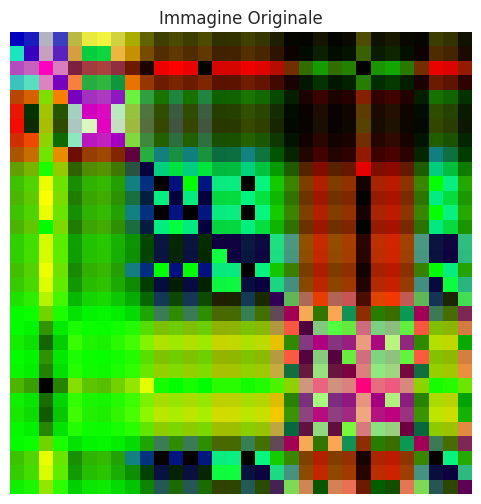

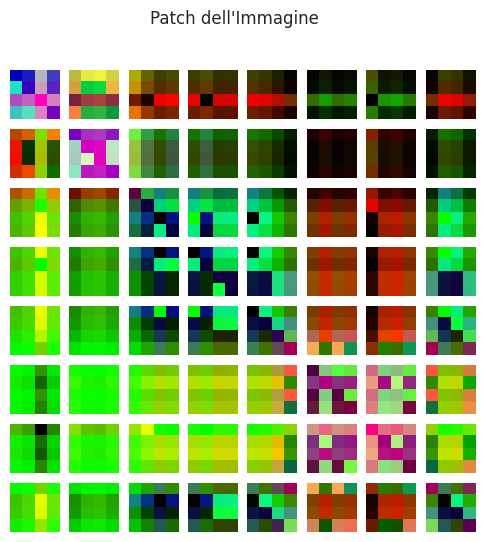

In [ ]:
# Load a sample image path from the training DataFrame
sample_image_path = train_df.iloc[0]["image_path"]  # Replace train_df with your actual DataFrame

# Load the image from the file (assuming it is stored as a NumPy .npy file)
sample_image = np.load(sample_image_path).astype(np.float32) / 255.0  # Normalize to [0, 1]

# Define the patch size
PATCH_SIZE = 32  # Example patch size

# Extract patches from the image
patches = extract_patches(sample_image, PATCH_SIZE)

# Visualize the original image
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Visualize the extracted patches
NUM_PATCHES = patches.shape[0]  # Total number of patches
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches):
    plt.subplot(int(np.sqrt(NUM_PATCHES)), int(np.sqrt(NUM_PATCHES)), i + 1)
    plt.imshow(patch)
    plt.axis("off")
plt.suptitle("Image Patches")
plt.show()


In [ ]:
# Define a function to calculate and plot the confusion matrix
def plot_confusion_matrix(test_ds, model, class_labels):
    """
    Calculate and plot the confusion matrix with percentages for a classification model.

    Parameters:
    - test_ds (Dataset): A dataset containing test image batches and their corresponding labels.
    - model (Model): The trained classification model.
    - class_labels (list): A list of strings representing class labels for the confusion matrix.

    Returns:
    - cm (ndarray): The confusion matrix as a 2D numpy array.
    - cm_percent (ndarray): The confusion matrix with percentages as a 2D numpy array.
    """
    # Collect ground truth labels (y_true) and model predictions (y_pred)
    y_true = []
    y_pred = []

    for image_batch, label_batch in test_ds:
        predictions = model.predict(image_batch)
        y_true.extend(label_batch.numpy())  # Append ground truth labels
        y_pred.extend([round(pred.item()) for pred in predictions])  # Append rounded predictions

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentage for each cell relative to the total samples for that class
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Plot the confusion matrix with both absolute numbers and percentages
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    # Add percentages to the heatmap
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j + 0.25, i + 0.5, f'{cm_percent[i][j]:.2f}%', 
                     ha='center', va='center', color='black')

    # Set axis labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (with Percentages)')
    plt.show()

    return cm, cm_percent

In [ ]:
class_labels = ["Class 0", "Class 1"]
cm, cm_percent = plot_confusion_matrix(test_ds=test_ds_classification, model=model, class_labels=class_labels)

# 6. Model Saving

After training, we save the trained model.


In [ ]:
def save_model(model: tf.keras.Model, model_save_path: str) -> None:
    """
    Saves the trained model to the specified path.

    Parameters:
    - model (tf.keras.Model): The trained model to save.
    - model_save_path (str): Path where the model will be saved.
    """
    # Creazione della directory se non esiste
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

    # Save
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

save_model(model, model_save_path)